In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

import matplotlib.pyplot as plt


In [2]:
vocab_size = 5000
embedding_dim = 64
max_length = 15
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [3]:
news_json = pd.read_json("News_Category_Dataset_v2.json", lines=True)
news_json['category'] = news_json['category'].str.split(' ').str[0]
news_json = news_json.query('category == "POLITICS" or category == "WELLNESS" or category == "ENTERTAINMENT" or category == "TRAVEL" or category == "STYLE" or category == "PARENTING"')
news_json = news_json.sample(frac=1).reset_index(drop=True)
news_json

,category,headline,authors,link,short_description,date
0,ENTERTAINMENT,This 'Bachelorette' Fight About What Engagemen...,"Claire Fallon, Emma Gray, and Nick Offenberg",https://www.huffingtonpost.com/entry/this-bach...,"Looks like someone forgot that ""The Bacheloret...",2017-07-25
1,WELLNESS,My Name Is... 'Veginem',"Abby Heugel, Contributor\nAward-winning humor ...",https://www.huffingtonpost.com/entry/vegan-lif...,This is to be read in the same rhythm -- minus...,2013-08-06
2,POLITICS,GOP Senator Throws 'Talking Stick' During Shut...,Lee Moran,https://www.huffingtonpost.com/entry/talking-s...,"""Nicely Symbolic.""",2018-01-23
3,POLITICS,Tweeters Rip Trump Over 'Tone Deaf' Thumbs-Up ...,Lee Moran,https://www.huffingtonpost.com/entry/donald-tr...,"""To give a thumbs-up like you just had a great...",2018-02-17
4,POLITICS,Treasury Department Renames Building To Honor ...,Philip Lewis,https://www.huffingtonpost.com/entry/treasury-...,"""It's a narrative for a new movement.""",2015-12-08
...,...,...,...,...,...,...
97086,STYLE,Summer Style Trend: Embroidery,"Condiment, Contributor\nDigital magazine and m...",https://www.huffingtonpost.com/entry/summer-st...,Embroidery is said to date back to the fifteen...,2013-06-03
97087,STYLE,Amazon Photoshop Fail Is The Strangest Thing W...,,https://www.huffingtonpost.com/entry/amazon-ph...,[H/T Photoshop Disasters] PHOTOS: If you wante...,2013-08-06
97088,POLITICS,Blowing Up Heads,"Robert Brustein, ContributorPlaywright, direct...",https://www.huffingtonpost.com/entry/blowing-u...,It has become more and more evident that the m...,2014-12-21
97089,STYLE,In Defense of New Year's Resolutions,"Daniel G Hill, Contributor\nPresident, Hill Im...",https://www.huffingtonpost.com/entry/in-defens...,"If you listen to the resolution-haters, we res...",2012-12-31


In [4]:
dataset = news_json[['category', 'headline']]
dataset[0:20]

,category,headline
0,ENTERTAINMENT,This 'Bachelorette' Fight About What Engagemen...
1,WELLNESS,My Name Is... 'Veginem'
2,POLITICS,GOP Senator Throws 'Talking Stick' During Shut...
3,POLITICS,Tweeters Rip Trump Over 'Tone Deaf' Thumbs-Up ...
4,POLITICS,Treasury Department Renames Building To Honor ...
5,POLITICS,George Takei Destroyed Trump On Twitter During...
6,POLITICS,Jeff Sessions Confirmed As Attorney General
7,STYLE,Kate Middleton's Pregnancy: What The Fashion W...
8,PARENTING,Why are Education Apps Built by the Lowest Bui...
9,POLITICS,Wednesday's Morning Email: Trump Reportedly As...


In [5]:
train_size = int(len(dataset) * 0.8)
train_data = dataset[0:train_size]
test_data = dataset[train_size:]
train_data, test_data

(            category                                           headline
 0      ENTERTAINMENT  This 'Bachelorette' Fight About What Engagemen...
 1           WELLNESS                            My Name Is... 'Veginem'
 2           POLITICS  GOP Senator Throws 'Talking Stick' During Shut...
 3           POLITICS  Tweeters Rip Trump Over 'Tone Deaf' Thumbs-Up ...
 4           POLITICS  Treasury Department Renames Building To Honor ...
 ...              ...                                                ...
 77667       POLITICS  Democrats Struggle To Win Over Skeptical Ameri...
 77668         TRAVEL  Water Parks in New Jersey: A Huffington Post T...
 77669      PARENTING                             The Best Mom, Probably
 77670       WELLNESS  Am I a Yogi If I'm Not a Vegetarian? A Closer ...
 77671         TRAVEL  Rosario Dawson Talks About Why She Loves Ridin...
 
 [77672 rows x 2 columns],
             category                                           headline
 77672       POLITICS 

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['headline'])
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 'in': 6,
 'and': 7,
 'for': 8,
 'is': 9,
 'on': 10}

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_data['headline'])
train_sequences[0:10]

[[23, 1, 249, 21, 24, 2208, 1049, 9, 161, 221],
 [45, 582, 9, 1],
 [51, 481, 2811, 1, 1, 211, 1098, 691, 1283, 3292, 3945],
 [3818, 2872, 11, 53, 1, 1, 1, 39, 2812, 13, 478, 63, 1],
 [3071, 606, 1, 1780, 3, 1131, 1, 1],
 [460, 1, 1, 11, 10, 253, 211, 2, 251],
 [587, 912, 3390, 32, 1132, 902],
 [224, 2429, 710, 24, 2, 77, 95, 57, 3, 137, 21, 2, 121, 259, 12],
 [28, 20, 903, 1481, 1, 43, 2, 1, 1],
 [1592, 198, 205, 11, 435, 1099, 2, 2534, 470, 404, 59, 86, 2085, 8]]

In [8]:
train_pad = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_pad[100:110]

array([[1253,  359,  301,    1,    1,   39,  359, 1452,   32, 4360,    1,
           0,    0,    0,    0],
       [  11, 1595,    3,  122, 1906, 1084,   26,    1,   69,   70, 2090,
          10,  607,    0,    0],
       [ 374, 4692,    1,  832,  432,  124,  970, 3394,    0,    0,    0,
           0,    0,    0,    0],
       [1235,    3, 2051, 2479,    6, 1134,    7,  976,  188,  175,    0,
           0,    0,    0,    0],
       [ 295,  436,   67, 2052,  284,  610,    1,   26,  668,  505,  272,
        2382,    0,    0,    0],
       [1907,    4,  457, 3395,    6, 2128,  127, 3589,   32, 1872, 3950,
           0,    0,    0,    0],
       [  28,   52,   76,   55,  154,    5, 3590,    8,  215,    7,  650,
         184,    0,    0,    0],
       [ 599,    1,    1,    1, 4361,   63,  491,  862,   27,   56,   27,
           0,    0,    0,    0],
       [ 700, 2091,  539,    1,  886,  142, 2814,    1,   75, 3298,    8,
        1873,    0,    0,    0],
       [   1,   89,  320, 1816,   36,

In [9]:
test_sequences = tokenizer.texts_to_sequences(test_data['headline'])
test_pad = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_pad[1:10]

array([[4854,    1,  207,   82,  150,  118, 1821,  186,   53,    1,  455,
        3863,   10,   34,  523],
       [1846,    1,    9, 2150,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  64,  659,  848,  758,   33,  358,    4,  796,  205,    0,    0,
           0,    0,    0,    0],
       [   9, 2026,   67,    5,  144,  709, 1756,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1, 4268, 1129, 2467,    6,  127,   13,  685,  118,    0,    0,
           0,    0,    0,    0],
       [4130,    4,  894, 2594,    1,    1,    9,    1,   39,    0,    0,
           0,    0,    0,    0],
       [   9,   15,   74,    1,   43,    1,  134,    3, 3440,   27,    0,
           0,    0,    0,    0],
       [1201,   40,  610,   19, 1477,  183,   12,    9,    5,  742,    3,
        3864, 1209, 2932,   30],
       [ 165,    2,   63,   96,    4, 3755,    1,  125,  754,    0,    0,
           0,    0,    0,    0]])

In [10]:
category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(dataset['category'])

train_category_sequence = np.array(category_tokenizer.texts_to_sequences(train_data['category']))
test_category_sequence = np.array(category_tokenizer.texts_to_sequences(test_data['category']))
train_category_sequence[0:11]

array([[3],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [4],
       [6],
       [1],
       [6]])

In [11]:
import sklearn
from sklearn.mixture import GaussianMixture as GMM
print("imported")

imported


In [18]:
gmm = GMM(n_components=6,covariance_type="full")
print("done")

done


In [19]:
gmm.fit(train_pad)
print("done")

done


In [20]:
gmm_pred =gmm.predict(test_pad)

print(gmm_pred)

[2 3 1 ... 1 1 1]


In [21]:
sklearn.metrics.accuracy_score(test_category_sequence, gmm_pred)

0.2110304341109223

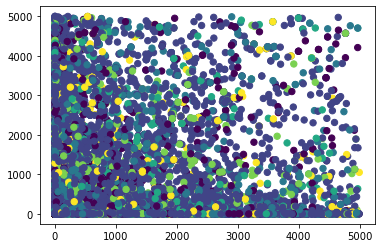

In [22]:
plt.scatter(test_pad[:, 0], test_pad[:, 1], c=gmm_pred, s=40, cmap='viridis');